In [1]:
# This notebook illustrates example outputs from Funman, and how to work with the ParameterSpace object it creates.

# The file scratch/hackathon/hackathon_fall_2023_demo_terarrium.py was used to generate the outputs rendered here.

SAVED_RESULTS_DIR = "./out"

# Import funman related code
import os
from funman.api.run import Runner
from funman_demo import summarize_results
from funman_demo.example.pde import plot_spatial_timeseries
from IPython.display import HTML
import matplotlib.pyplot as plt
import itertools
from funman import FunmanWorkRequest, EncodingSchedule, POS_INFINITY

import json
from funman.representation.constraint import LinearConstraint, ParameterConstraint, StateVariableConstraint
from funman.representation import Interval
from funman import FUNMANConfig
import logging
from funman_demo import summarize_results



RESOURCES = "../resources"
EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "terrarium-tests")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR,"seird.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "seird_request.json"
)


# EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "stratified")
# MODEL_PATH = os.path.join(
#     EXAMPLE_DIR,"model_amr.json"
# )
# REQUEST_PATH = os.path.join(
#     EXAMPLE_DIR, "model_amr_request.json"
# )


# %load_ext autoreload
# %autoreload 2

Automatic initialization of gaol... done
2024-03-15 21:31:50,369 - /root/funman/src/funman/search/smt_check.py - DEBUG - Solving schedule: timepoints=[0, 10, 20]
2024-03-15 21:31:50,372 - funman_dreal.solver - DEBUG - Created new Solver ...
2024-03-15 21:31:50,402 - /root/funman/src/funman/translate/petrinet.py - DEBUG - Encoding step: 0 to 10
2024-03-15 21:31:50,502 - /root/funman/src/funman/translate/petrinet.py - DEBUG - Encoding step: 10 to 20


name='beta' interval={'lb': 0, 'ub': 1.833, 'closed_upper_bound': True, 'original_width': 0.0} label='any'
name='epsilon' interval={'lb': 0, 'ub': 1.3333333333333335, 'closed_upper_bound': True, 'original_width': 0.0} label='any'
name='gamma' interval={'lb': 0, 'ub': 1.125, 'closed_upper_bound': True, 'original_width': 0.0} label='any'
name='alpha' interval={'lb': 0, 'ub': 1.006, 'closed_upper_bound': True, 'original_width': 0.0} label='any'
name='lambda' interval={'lb': 120479.0, 'ub': 120481.0, 'closed_upper_bound': True, 'original_width': 0.0} label='any'
name='mu' interval={'lb': 0, 'ub': 1.012048, 'closed_upper_bound': True, 'original_width': 0.0} label='any'
name='City' interval={'lb': 0.0, 'ub': 2.0, 'closed_upper_bound': True, 'original_width': 0.0} label='any'


2024-03-15 21:31:55,309 - funman.api.run - INFO - Dumping results to ./out/7d5e7746-c011-4d17-a50e-5647db2c0b91.json
2024-03-15 21:31:55,323 - funman.scenario.consistency - INFO - 2{20}:	[+]
2024-03-15 21:31:55,333 - funman.server.worker - INFO - Completed work on: 7d5e7746-c011-4d17-a50e-5647db2c0b91
2024-03-15 21:32:05,342 - funman.server.worker - INFO - Worker.stop() acquiring state lock ....
2024-03-15 21:32:05,344 - funman.server.worker - INFO - FunmanWorker exiting...
2024-03-15 21:32:05,347 - funman.server.worker - INFO - Worker.stop() completed.


Total # of ibex-fwdbwd Pruning                @ Pruning level        =          210127
Total # of ibex-fwdbwd Pruning (zero-effect)  @ Pruning level        =          159490
Total time spent in Pruning                   @ Pruning level        =        0.265446 sec
Total time spent in making constraints        @ Pruning level        =        0.000000 sec
Total # of Convert                            @ Ibex Converter       =              30
Total time spent in Converting                @ Ibex Converter       =        0.000721 sec


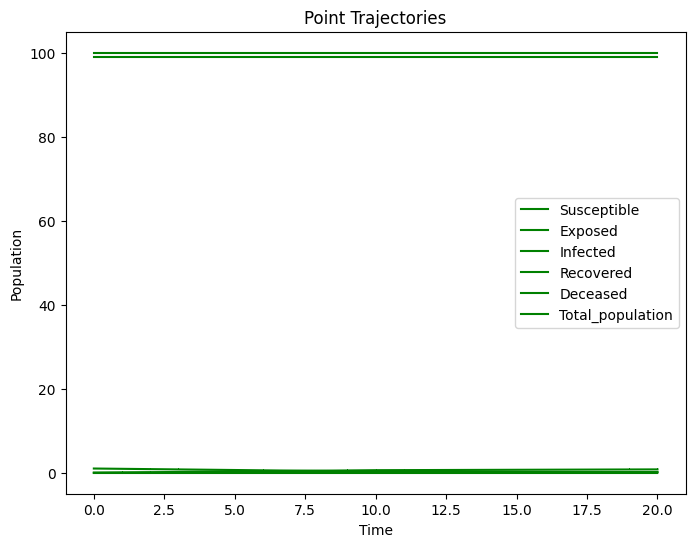

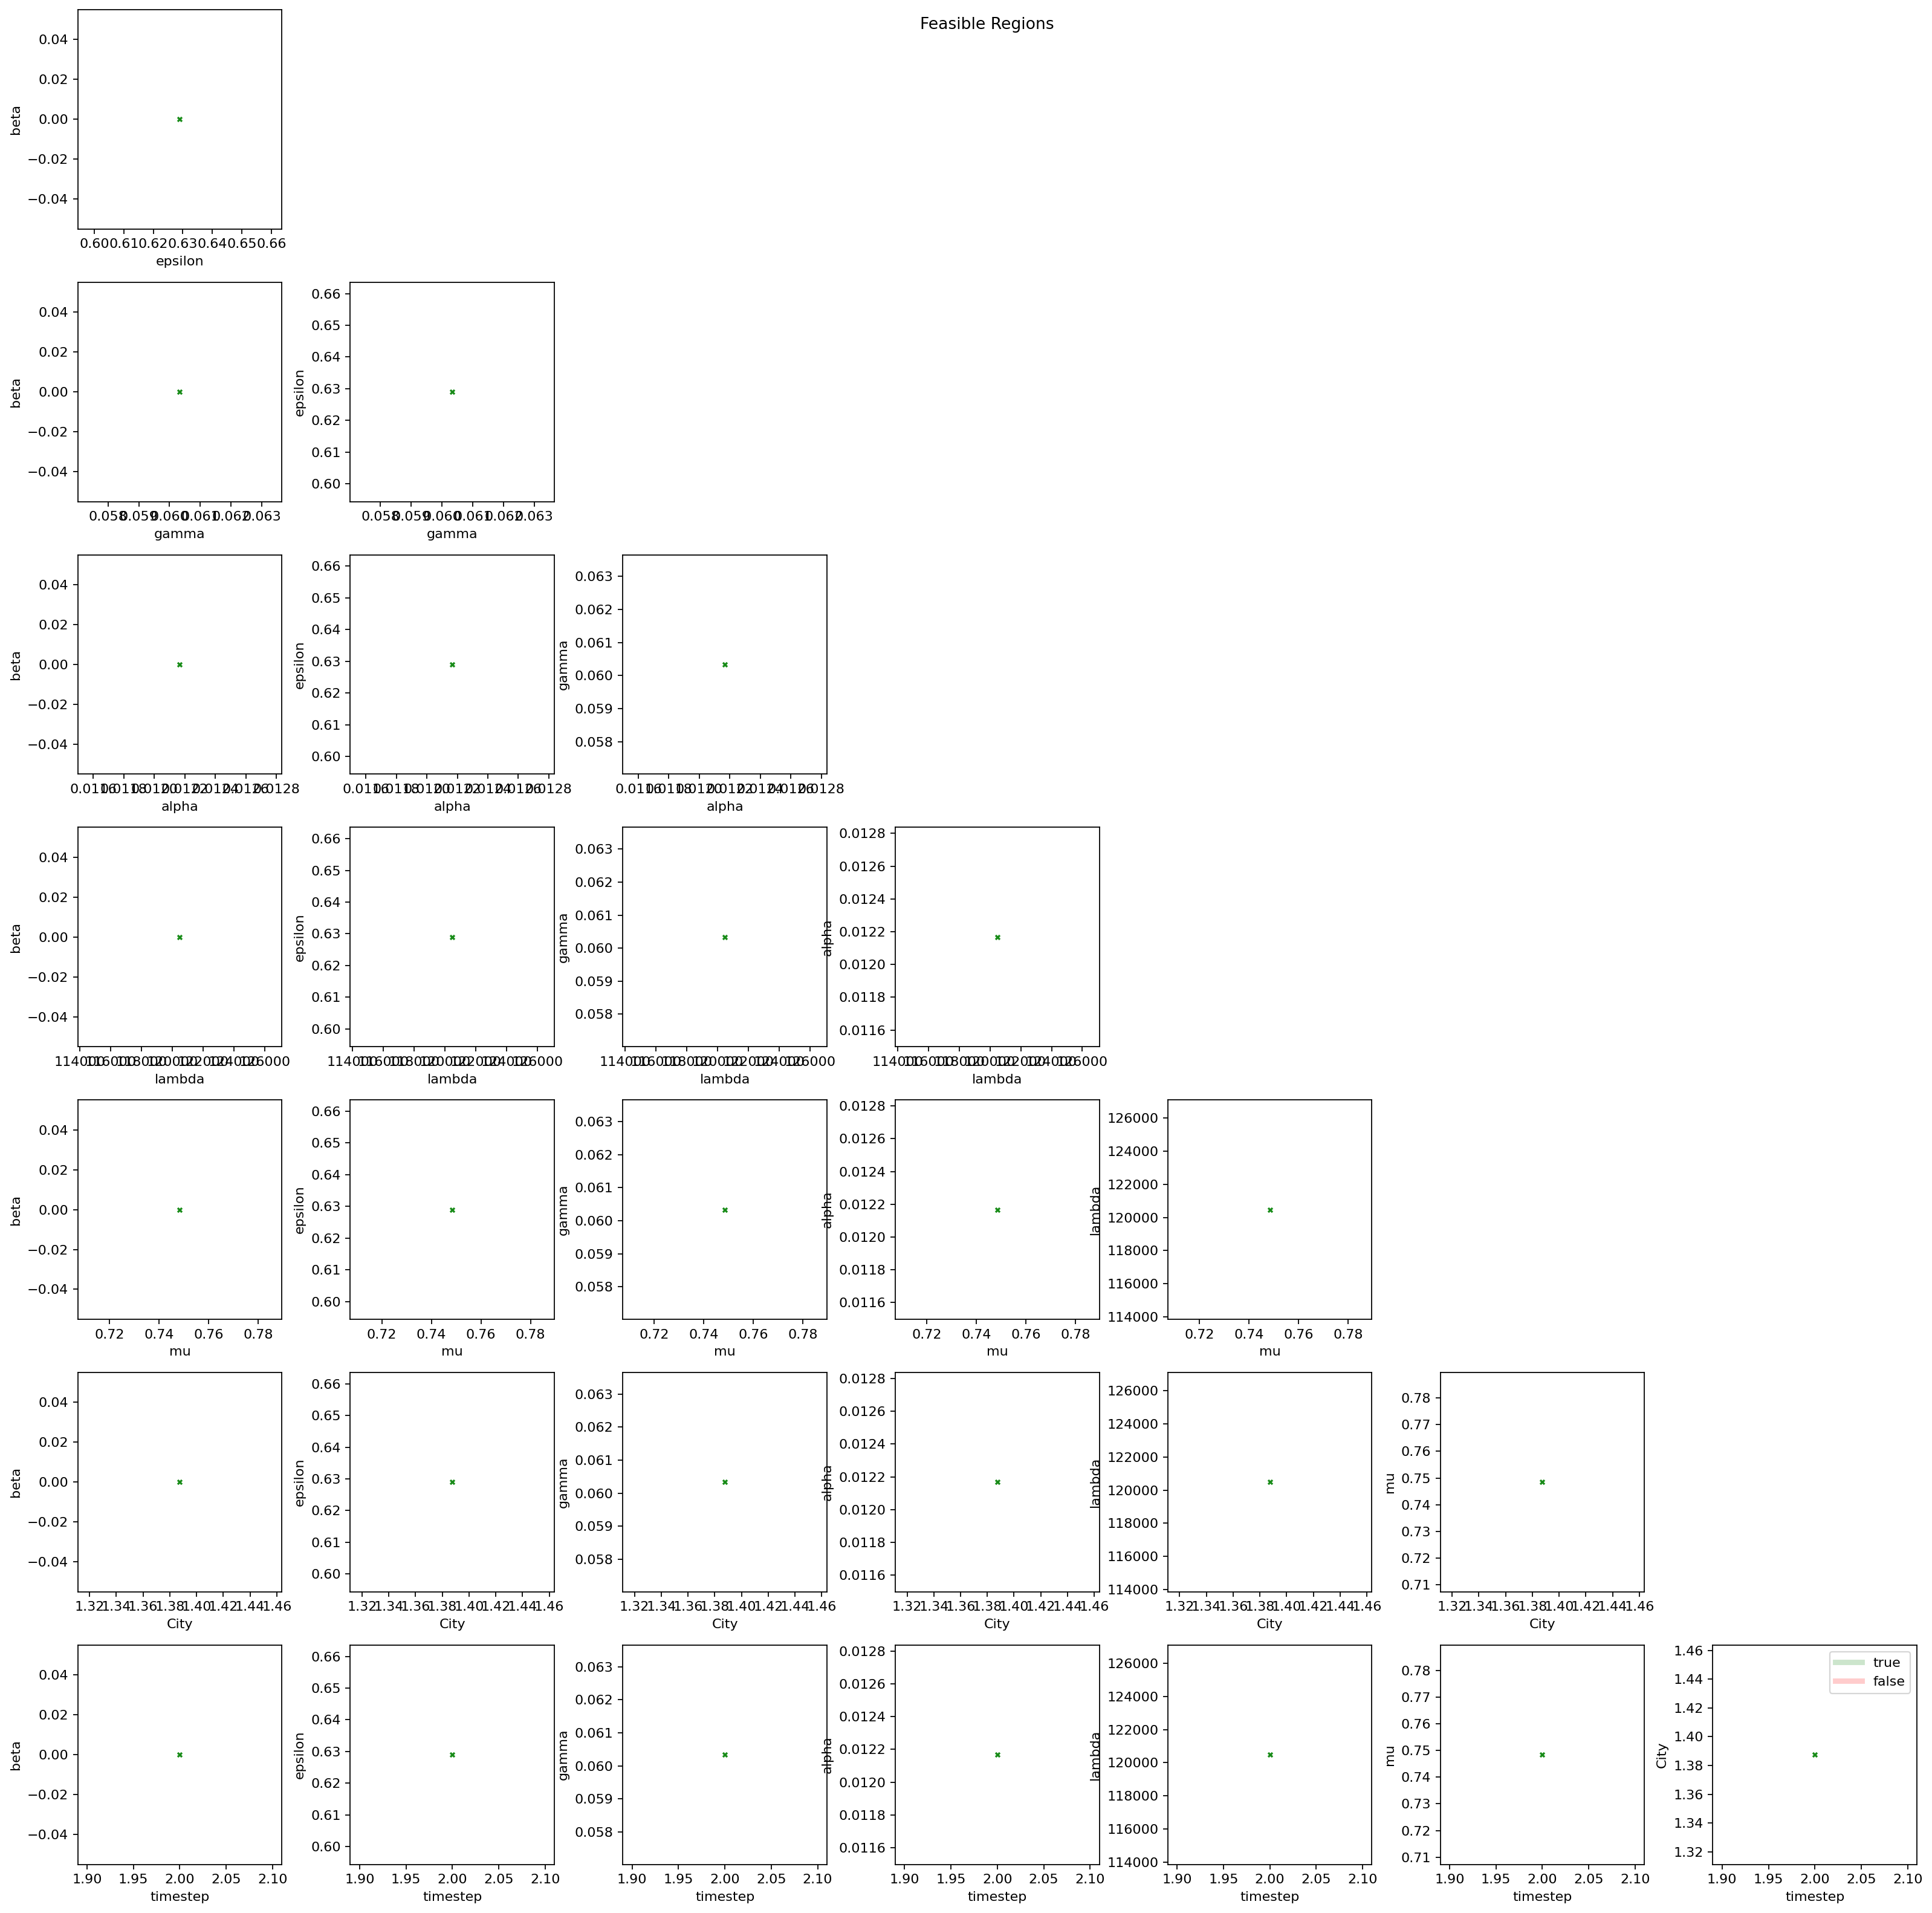

********************************************************************************
********************************************************************************
* Analysis Summary
********************************************************************************
1 Points (+:1, -:0), 1 Boxes (+:1, -:0)
Parameters = {beta[0, 1.833): 2.5e-322, epsilon[0, 1.3333333333333335): 0.628988076607717, gamma[0, 1.125): 0.06033634263731719, alpha[0, 1.006): 0.012167379326968451, lambda[120479.0, 120481.0): 120480.75931891351, mu[0, 1.012048): 0.7484558002587655, City[0.0, 2.0): 1.3875134480164828}
        # {beta[0, 1.833): 2.5e-322, epsilon[0, 1.3333333333333335): 0.628988076607717, gamma[0, 1.125): 0.06033634263731719, alpha[0, 1.006): 0.012167379326968451, lambda[120479.0, 120481.0): 120480.75931891351, mu[0, 1.012048): 0.7484558002587655, City[0.0, 2.0): 1.3875134480164828}
                  City  Deceased        Exposed  Infected  Recovered  Susceptible  \
time                                  

In [2]:
# Feb 2024 Hackathon Scenario 3 (SEIRD)

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "mira")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR, "models", "scenario_3_seird.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "requests", "scenario_3_seird_request.json"
)


N = "Total_population"
STATES = ["Susceptible", "Exposed", "Infected", "Recovered", "Deceased"]
COMPARTMENTS = STATES + [N]

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=list(range(0, 30, 10)))

    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    funman_request.config.use_compartmental_constraints=True
    funman_request.config.save_smtlib="./out"
    funman_request.config.tolerance = 0.001
    funman_request.config.verbosity = 10
    funman_request.config.dreal_log_level = "info"

    factor = 1
    to_synthesize = ["beta"]
    for p in [po for po in funman_request.parameters if po.name not in []]:
        param = funman_request.parameter(p.name)
        param.interval.lb = max(p.interval.lb-factor, 0)
        param.interval.ub = min(p.interval.ub+factor, max(1, p.interval.ub+factor))
        # param.label = "all" if p.name in to_synthesize else "any"
        print(param)

    # Susceptible is decreasing,  dS/dt <= 0, S_{t+1} - S_t <= 0
    c1 = LinearConstraint(name="c1", additive_bounds=Interval(ub=0, closed_upper_bounds=True), variables=["Susceptible"], derivative=True)
    funman_request.constraints.append(c1)

    # # R is increasing, dR/dt >= 0,   R_{t+1} - R_t >= 0
    c2 = LinearConstraint(name="c2", additive_bounds=Interval(lb=0), variables=["Recovered"], derivative=True)
    funman_request.constraints.append(c2)

    # # D is increasing, dD/dt >= 0, dD/dt >= 0,   D_{t+1} - D_t >= 0
    c3 = LinearConstraint(name="c3", additive_bounds=Interval(lb=0), variables=["Deceased"], derivative=True)
    funman_request.constraints.append(c3)

    # # Population size maintained
    # c4 = LinearConstraint(name="compartment", additive_bounds=Interval(lb=0, ub=0, closed_upper_bound=True), variables=COMPARTMENTS, weights=[1, 1, 1, 1, 1, -1])
    # funman_request.constraints.append(c4)

    # # Infected peak
    # c5 = LinearConstraint(name="Infected_peak", additive_bounds=Interval(lb=50), variables=["Infected"], timepoints=Interval(lb=40, ub=40, closed_upper_bound=True))
    # funman_request.constraints.append(c5)

    for sv in STATES:
        funman_request.constraints.append(StateVariableConstraint(name=f"{sv}_bounds", variable=sv, interval=Interval(lb=0, ub=100, closed_upper_bound=True)))
    

    


    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    summary = summarize_results(COMPARTMENTS, results_unconstrained_point, ylabel="Population", synthesized_parameters=to_synthesize+["timestep"])
    print(summary)

In [2]:
# Feb 2024 Hackathon Scenario 3.3 (SEIRD)

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet", "mira")
MODEL_PATH = os.path.join(
    EXAMPLE_DIR, "models", "scenario_3_seird_stratified.json"
)
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "requests", "scenario_3_seird_request_stratified.json"
)


N = "Total_population"
STATES_Vax = ["Susceptible_Vax", "Exposed_Vax", "Infected_Vax", "Recovered_Vax", "Deceased_Vax"]
STATES_UnVax = ["Susceptible_UnVax", "Exposed_UnVax", "Infected_UnVax", "Recovered_UnVax", "Deceased_UnVax"]
STATES = STATES_UnVax + STATES_Vax
COMPARTMENTS = STATES_Vax + STATES_UnVax + [N]
MAX_TIME=100

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=list(range(0, MAX_TIME, 10)))

    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    funman_request.config.use_compartmental_constraints=False
    funman_request.config.save_smtlib="./out"
    funman_request.config.tolerance = 0.001
    # funman_request.config.verbosity = 5
    # funman_request.config.dreal_log_level = "trace"

    factor = .1
    to_synthesize = ["beta_Vax", "beta_UnVax"]
    for p in [po for po in funman_request.parameters if po.name not in ["t_mask", "mask"]]:
        param = funman_request.parameter(p.name)
        
        param.interval.lb = max(p.interval.lb-factor, min(0, p.interval.lb))
        param.interval.ub = min(p.interval.ub+factor, max(1, p.interval.ub))
    #     # param.label = "all" if p.name in to_synthesize else "any"

    param = funman_request.parameter("t_mask")
    param.interval.lb = 20
    param.interval.ub = 20

    # dVax/dt > 0  -(Vax_{t+1}-Vax_t) < 0
    inc_vax = LinearConstraint(name="inc_vax", additive_bounds=Interval(ub=0), variables=STATES_Vax, derivative=True, weights=[-1]*len(STATES_Vax))
    funman_request.constraints.append(inc_vax)

    # dUnVax/dt < 0  (UnVax_{t+1}-UnVax_t) < 0
    dec_unvax = LinearConstraint(name="dec_unvax", additive_bounds=Interval(ub=0), variables=STATES_UnVax, derivative=True)
    funman_request.constraints.append(dec_unvax)

    # Susceptible is decreasing,  dS/dt =< 0, S_{t+1} - S_t =< 0
    c1 = LinearConstraint(name="c1", additive_bounds=Interval(ub=0, closed_upper_bound=True), variables=["Susceptible_Vax", "Susceptible_UnVax"], derivative=True, timepoints=Interval(lb=0))
    funman_request.constraints.append(c1)

    # # R is increasing, dR/dt >= 0
    c2 = LinearConstraint(name="c2", additive_bounds=Interval(lb=0), variables=["Recovered_Vax", "Recovered_UnVax"],  derivative=True, timepoints=Interval(lb=0))
    funman_request.constraints.append(c2)

    # # D is increasing, dD/dt >= 0
    c3 = LinearConstraint(name="c3", additive_bounds=Interval(lb=0), variables=["Deceased_Vax", "Deceased_UnVax"], derivative=True,  timepoints=Interval(lb=0))
    funman_request.constraints.append(c3)
    

    # Population size maintained
    c4 = LinearConstraint(name="compartment", additive_bounds=Interval(lb=0, ub=0, closed_upper_bound=True), variables=COMPARTMENTS, weights=[1]*len(STATES) + [-1])
    funman_request.constraints.append(c4)

    # # Infected peak
    # c5 = LinearConstraint(name="Infected_peak", additive_bounds=Interval(lb=10), variables=["Infected_Vax", "Infected_UnVax"], timepoints=Interval(lb=40, ub=40, closed_upper_bound=True))
    # funman_request.constraints.append(c5)

    for sv in STATES:
        funman_request.constraints.append(StateVariableConstraint(name=f"{sv}_bounds", variable=sv, interval=Interval(lb=0, ub=100, closed_upper_bound=True)))
    


    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    summary = summarize_results(COMPARTMENTS, results_unconstrained_point, ylabel="Population", synthesized_parameters=to_synthesize+["timestep"])
    print(summary)

Automatic initialization of gaol... done


In [3]:
results_unconstrained_point.parameter_space.points()[0]
df= results_unconstrained_point.dataframe(
    results_unconstrained_point.parameter_space.points()
)
df[COMPARTMENTS]
# df["S"]+df["E"]+df["I"]+df["D"]

,Susceptible_Vax,Exposed_Vax,Infected_Vax,Recovered_Vax,Deceased_Vax,Susceptible_UnVax,Exposed_UnVax,Infected_UnVax,Recovered_UnVax,Deceased_UnVax,Total_population
time,,,,,,,,,,,
0.0,0.000000,0.000000,1.000000,0.000000,0.000000,98.000000,0.000000,1.000000,0.000000,0.000000,100.0
1.0,2.416951,0.000000,0.943061,0.033442,0.047264,94.713914,0.866637,0.902980,0.028877,0.043489,100.0
2.0,4.833902,0.000000,0.886123,0.066884,0.094529,91.427828,1.733274,0.805960,0.057754,0.086977,100.0
3.0,7.250853,0.000000,0.829184,0.100326,0.141793,88.141743,2.599911,0.708940,0.086632,0.130466,100.0
4.0,9.667803,0.000000,0.772245,0.133768,0.189057,84.855657,3.466549,0.611920,0.115509,0.173955,100.0
5.0,12.084754,0.000000,0.715307,0.167210,0.236321,81.569571,4.333186,0.514900,0.144386,0.217443,100.0
6.0,14.501705,0.000000,0.658368,0.200652,0.283586,78.283485,5.199823,0.417880,0.173263,0.260932,100.0
7.0,16.918656,0.000000,0.601430,0.234094,0.330850,74.997399,6.066460,0.320860,0.202140,0.304421,100.0
8.0,19.335607,0.000000,0.544491,0.267536,0.378114,71.711313,6.933097,0.223839,0.231017,0.347909,100.0


In [22]:
# results_unconstrained_point.parameter_space.points()[0]
# df= results_unconstrained_point.dataframe(
#     results_unconstrained_point.parameter_space.points()
# )
# df[COMPARTMENTS].describe() #.plot()
results_unconstrained_point.parameter_space.false_boxes[0].explanation.expression

'((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((solve_step_0 & assume_Deceased_bounds) & assume_Recovered_bounds) & assume_Infected_bounds) & assume_Exposed_bounds) & assume_Susceptible_bounds) & assume_compartment) & disj1095) & (alpha <= 10060000000000001/10000000000000000)) & (epsilon <= 2666666666666667/2000000000000000)) & solve_step_2) & solve_step_1) & disj1109) & assume_c3_20) & assume_c2_20) & disj1129) & disj1132) & (beta < 6823503167783207/25000000000000000)) & (gamma < 1/512)) & ((conj1471 | (! assume_Infected_bounds)) | (! disj1092))) & (disj1092 | (! conj1474))) & ((conj1472 | (! assume_Susceptible_bounds)) | (! disj1093))) & (disj1093 | (! conj1474))) & ((conj1474 | (! solve_step_0)) | (! disj1095))) & ((Deceased_0 = 0.0) | (! conj1474))) & ((Recovered_0 = 0.0) | (! conj1474))) & ((Exposed_0 = 0.0) | (! conj1474))) & (((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((Infected_0 < 0.0) | (Sus

In [23]:
import textwrap
expr = results_unconstrained_point.parameter_space.false_boxes[0].explanation.expression
print(textwrap.fill(expr, 80))


((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((
((((((((((((((((((((((((((((((((((((solve_step_0 & assume_Deceased_bounds) &
assume_Recovered_bounds) & assume_Infected_bounds) & assume_Exposed_bounds) &
assume_Susceptible_bounds) & assume_compartment) & disj1095) & (alpha <=
10060000000000001/10000000000000000)) & (epsilon <=
2666666666666667/2000000000000000)) & solve_step_2) & solve_step_1) & disj1109)
& assume_c3_20) & assume_c2_20) & disj1129) & disj1132) & (beta <
6823503167783207/25000000000000000)) & (gamma < 1/512)) & ((conj1471 | (!
assume_Infected_bounds)) | (! disj1092))) & (disj1092 | (! conj1474))) &
((conj1472 | (! assume_Susceptible_bounds)) | (! disj1093))) & (disj1093 | (!
conj1474))) & ((conj1474 | (! solve_step_0)) | (! disj1095))) & ((Deceased_0 =
0.0) | (! conj1474))) & ((Recovered_0 = 0.0) | (! conj1474))) & ((Exposed_0 =
0.0) | (! conj1474))) &
(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((Infected_0 < 0.0)
| (Sus

In [ ]:
# SEIRHD

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=[0, 1])

    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    funman_request.config.use_compartmental_constraints=False
    funman_request.config.save_smtlib="./out"

    for p in [po.name for po in funman_request.parameters if po.name not in ["S0", "I0", "E0", "R0", "H0", "D0", "N", "beta"]]:
    #["beta", "r_H_to_D", "r_E_to_I", "p_I_to_R", "r_I_to_R",  "p_I_to_H", "r_I_to_H", "p_H_to_R", "r_H_to_R","p_H_to_D","r_H_to_D"]:
        param = funman_request.parameter(p)
        param.interval.lb = 0
        param.interval.ub = 1

    # S is decreasing,  dS/dt < 0, S_{t+1} - S_t < 0
    c1 = LinearConstraint(name="c1", additive_bounds=Interval(ub=0), variables=["S"], derivative=True)
    funman_request.constraints.append(c1)

    # R is increasing, dR/dt > 0, -dR/dt < 0,   - (R_{t+1} - R_t) < 0
    c2 = LinearConstraint(name="c2", additive_bounds=Interval(ub=0), variables=["R"], weights=[-1], derivative=True)
    funman_request.constraints.append(c2)

    # D is increasing, dD/dt > 0, -dD/dt < 0,   - (D_{t+1} - D_t) < 0
    c3 = LinearConstraint(name="c3", additive_bounds=Interval(lb=0), variables=["D"], derivative=True)
    funman_request.constraints.append(c3)

    # Population size maintained
    c4 = LinearConstraint(name="compartment", additive_bounds=Interval(lb=0, ub=0, closed_upper_bound=True), variables=["S", "E", "I", "R", "D", "H", "N"], weights=[1, 1, 1, 1, 1, 1, -1])
    funman_request.constraints.append(c4)

    funman_request.constraints.append(StateVariableConstraint(name="SB", variable="S", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="EB", variable="E", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="IB", variable="I", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="RB", variable="R", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="DB", variable="D", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    funman_request.constraints.append(StateVariableConstraint(name="HB", variable="H", interval=Interval(lb=0, ub=101, closed_upper_bound=True)))
    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    summary = summarize_results(["S", "E", "I", "R", "H", "D"], results_unconstrained_point, ylabel="Population")
    print(summary)

In [9]:
json.loads(c2.model_dump_json())

{'soft': True,
 'name': 'c2',
 'timepoints': None,
 'additive_bounds': {'lb': -1.7976931348623157e+308,
  'ub': 0.0,
  'closed_upper_bound': False,
  'original_width': 1.7976931348623157e+308},
 'variables': ['R'],
 'weights': [-1],
 'derivative': True}

In [ ]:
import json
json.loads(results_unconstrained_point.parameter_space.false_boxes[0].explanation.model_dump_json())#['relevant_assumptions']

In [ ]:
results_unconstrained_point.parameter_space.points()[0]
df= results_unconstrained_point.dataframe(
    results_unconstrained_point.parameter_space.points()
)
df[["S", "E", "I", "R", "H", "D"]]
# df["S"]+df["E"]+df["I"]+df["D"]

In [ ]:
# Stratified

with open(REQUEST_PATH, "r") as request:
    funman_request = FunmanWorkRequest.model_validate(json.load(request))
    funman_request.structure_parameters[0].schedules[0] = EncodingSchedule(timepoints=[0,1, 2])
    funman_request.config.substitute_subformulas = True
    funman_request.config.use_transition_symbols = True
#     funman_request.config.use_compartmental_constraints=False
#     r_H_to_D = funman_request.parameter("r_H_to_D")
#     r_H_to_D.interval.lb = 0
#     r_H_to_D.interval.ub = 1.0

    # r_E_to_I = funman_request.parameter("r_E_to_I")
    # r_E_to_I.interval.lb = 0
    # r_E_to_I.interval.ub = 1.0


    results_unconstrained_point = Runner().run(
            MODEL_PATH,
            funman_request,
            description="SEIRD demo",
            case_out_dir=SAVED_RESULTS_DIR,
    )
    # summary = summarize_results(["S", "E", "I", "R", "D"], results_unconstrained_point, ylabel="Population")
    # print(summary)

In [ ]:
results_unconstrained_point.parameter_space.points()[0]